# Steps for preparation for docking: 
1. get the protein pdb file using ECnumber 
2. make protein_file folder 
3. remove the residue 
4. remove the water 
5. make the protein pdbqt file¶

In [1]:
from rcsbsearchapi.search import TextQuery
from rcsbsearchapi import rcsb_attributes as attrs

ECnumber = "2.7.1.153"   # PIK3CA  

q1 = attrs.rcsb_polymer_entity.rcsb_ec_lineage.id == ECnumber  # looking for trypsins
q2 = TextQuery("KWT")            ## Fill in text query here

query = q1 & q2               # combining the two queries into one

results = list(query())
print(results)

['1E7U', '3HHM']


In [2]:
pdb_id = results[0].lower()    ## Get the PDB ID from the list and convert it to lowercase
print(pdb_id)


1e7u


In [3]:
# get the PDB file from pdb database and save them in folder: protein_files

import os # for making directories
import requests


# make a directory for pdb files
protein_directory = "protein_files"

## fill in function to make directories
os.makedirs(protein_directory, exist_ok=True)

pdb_id = "1e7u" # PIK3CA PDB file with ligand bound

pdb_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
pdb_request.status_code


200

In [4]:
with open(f"{protein_directory}/{pdb_id}.pdb", "w+") as f:
    f.write(pdb_request.text)

# Visualizing the protein strucure

In [5]:
import MDAnalysis as mda

# Load into MDA universe
u = mda.Universe(f"{protein_directory}/{pdb_id}.pdb")
u

/opt/conda/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


<Universe with 7249 atoms>

In [6]:
## create and show an NGLView from an MDAnalysis universe
import nglview as nv
view = nv.show_mdanalysis(u)
view

NGLWidget()

In [7]:
# Select protein atoms
protein = u.select_atoms("protein")
ligand = u.select_atoms("resname KWT")  # KWT is already attached to protein
water = u.select_atoms("resname HOH")  ## fill in selection for water.

#protein
#ligand
water

<AtomGroup with 164 atoms>

In [8]:
view = nv.show_mdanalysis(protein)
view.clear_representations()
## Add representation to view protein surface colored by hydrophobicity
view.add_representation("surface",colorScheme="hydrophobicity")

lig_view = view.add_component(ligand)
lig_view.add_representation("ball+stick")
water_view = view.add_component(water)
water_view.add_representation("spacefill")
view

NGLWidget()

In [9]:
# writing new protein structure without water, ligand , ready to docking
# Write protein to new PDB file
protein.write(f"{protein_directory}/protein_{pdb_id}.pdb")

/opt/conda/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


# Fixing the protein structure, correctly added hydrogen and fixed any missing atoms.

In [10]:
! pdb2pqr --pdb-output=protein_files/protein_h.pdb --pH=7.4 protein_files/protein_1e7u.pdb protein_files/protein_1e7u.pqr --whitespace


INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein_files/protein_1e7u.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     1>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 872 residues and 7054 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 5 missing atoms in biomolecule.
INFO:Added atom CG to residue LYS A 438 at coor

# Saving a protein PDBQT File 

In [11]:
# make a directory for pdb files
pdbqt_directory = "pdbqt_files"   ## fill in the name of the directory to write PDBQT files to
os.makedirs(pdbqt_directory, exist_ok=True)

u = mda.Universe(f"{protein_directory}/protein_{pdb_id}.pqr")
u.atoms.write(f"{pdbqt_directory}/{pdb_id}.pdbqt")

/opt/conda/lib/python3.11/site-packages/MDAnalysis/coordinates/PDBQT.py:295: UserWarning: Supplied AtomGroup was missing the following attributes: altLocs, occupancies, tempfactors. These will be written with default values. 
  warnings.warn(


In [12]:
# Read in the just-written PDBQT file, replace text, and write back
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'r') as file:
    file_content = file.read()

# Replace 'TITLE' and 'CRYST1' with 'REMARK'
file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')

# Write the modified content back to the file
with open(f"{pdbqt_directory}/{pdb_id}.pdbqt", 'w') as file:
    file.write(file_content)

## Ligand Preparation:

In [13]:
# Download one of the files from our list: 637511 

import requests

# Define PubChem CID
cid = "637511"

# URL to fetch the SDF file (3D structure)
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/SDF?record_type=3d"

# Download the file
response = requests.get(url)


In [14]:
# make a ligands folder for our results

import os


# Create "ligand" folder if it doesn't exist
folder_name = "ligand_files"
os.makedirs(folder_name, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_name, f"{cid}.sdf")


# Save the file in "ligand_files" folder
if response.status_code == 200:
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"SDF file for CID {cid} downloaded successfully and saved in '{folder_name}/' directory.")
else:
    print("Error downloading the file. Check CID and try again.")


SDF file for CID 637511 downloaded successfully and saved in 'ligand_files/' directory.


In [15]:
# Now we use these commands to read the file and make sure it downloaded properly. As an alternative, we
# could go to the ligands folder in our Jupyter desktop and click on 637511 to make sure it looks correct.

file1 = open('ligand_files/637511.sdf', 'r')
file_text = file1.read() # This reads in the file as a string.

print(file_text)

637511
  -OEChem-03142514573D

 18 18  0     0  0  0  0  0  0999 V2000
    4.3579    0.4145   -0.1669 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4363   -0.2819    0.0928 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8263    1.0571    0.1133 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3970   -1.2865   -0.0224 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1772    1.3916    0.0186 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7479   -0.9521   -0.1173 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.9725   -0.6306    0.1911 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.1379    0.3870   -0.0968 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0042    0.1995   -0.0732 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3880   -0.2986    0.0608 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1150    1.8710    0.2200 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1121   -2.3357   -0.0415 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1820   -1.6553    0.4922 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4820    2.433

In [16]:
# Use meeko to prepare small molecules - using meeko helps us visualize them later.
!mk_prepare_ligand.py -i ligand_files/637511.sdf -o pdbqt_files/637511.pdbqt



Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


## Preparing for Docking: Defining a Ligand Box

In [17]:
# find the center of the ligand
import MDAnalysis as mda

original_structure = mda.Universe("protein_files/1e7u.pdb")
ligand_mda = original_structure.select_atoms("resname KWT")

# Get the center of the ligand as the "pocket center"
pocket_center = ligand_mda.center_of_geometry() ## Fill in code for measuring the center of geometry of the ligand.
print(pocket_center)

[23.45035473 62.15712898 20.62703231]


In [18]:
# compute min and max coordinates of the ligand
# take the ligand box to be the difference between the max and min in each direction.
ligand_box = ligand_mda.positions.max(axis=0) - ligand_mda.positions.min(axis=0) +5 ## Fill in the rest of this expression.
ligand_box

array([13.184   , 12.426998, 13.042   ], dtype=float32)

In [19]:
pocket_center = pocket_center.tolist()
ligand_box = ligand_box.tolist()     ## convert ligand_box to list

### Docking Ligands with AutoDock Vina

In [20]:
# make a directory to store our results
import os

pdb_id = "1e7u"
ligand = "637511"

## Make a directory called "docking_results"
os.makedirs("docking_results", exist_ok=True)

In [21]:
from vina import Vina
v = Vina(sf_name="vina")

In [22]:
v.set_receptor(f"pdbqt_files/{pdb_id}.pdbqt")
v.set_ligand_from_file(f"pdbqt_files/{ligand}.pdbqt")  ## Fill in the ligand name
v.compute_vina_maps(center = pocket_center, box_size = ligand_box) ## Fill in the ligand center and box size calculated previously.

Computing Vina grid ... done.


In [24]:
v.dock(exhaustiveness=32, n_poses=5)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -5.283          0          0
   2       -5.273     0.4366      1.584
   3       -5.223      2.076      3.091
   4       -5.216      2.006      3.024
   5       -5.187      2.549      4.844
Performing docking (random seed: 1605823339) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [25]:
v.write_poses(f"docking_results/{ligand}.pdbqt", n_poses=5, overwrite=True)

In [26]:
## Fill in code to see the calculated energies for the poses.
v.energies()

array([[-5.262, -6.185, -0.193,  0.923, -0.193],
       [-5.261, -6.187, -0.19 ,  0.923, -0.193],
       [-5.212, -6.12 , -0.199,  0.914, -0.193],
       [-5.205, -6.104, -0.207,  0.913, -0.193],
       [-5.176, -6.136, -0.14 ,  0.908, -0.193]])

In [27]:
# save the energies

import pandas as pd


# These are the columns for the types of energies according to AutoDock Vina docs.
column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

df = pd.DataFrame(v.energies(), columns = column_names) ## Fill in arguments to the dataframe to create a dataframe with energies.
df.head()

,total,inter,intra,torsions,intra best pose
0,-5.262,-6.185,-0.193,0.923,-0.193
1,-5.261,-6.187,-0.190,0.923,-0.193
2,-5.212,-6.120,-0.199,0.914,-0.193
3,-5.205,-6.104,-0.207,0.913,-0.193
4,-5.176,-6.136,-0.140,0.908,-0.193


In [28]:
# Save the calculated energies from docking to a CSV file
df.to_csv("docking_results/637511_energies.csv", index=False) ## Fill in file name.

### Visualizing Docking Results

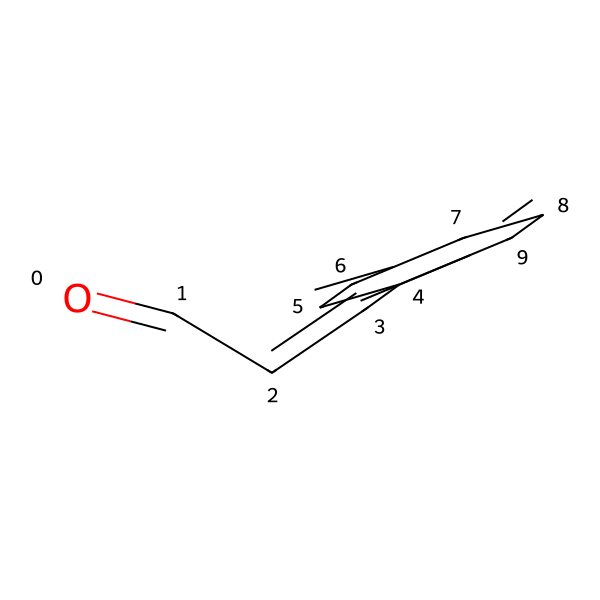

In [29]:
## visualization of ligand 
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Configuration for displaying in Jupyter notebooks
IPythonConsole.ipython_useSVG = True  # Use SVG for higher quality images
IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices
IPythonConsole.molSize = 600,600 # Set size of image

ligand = Chem.MolFromMolFile("docking_results/637511.sdf")
ligand

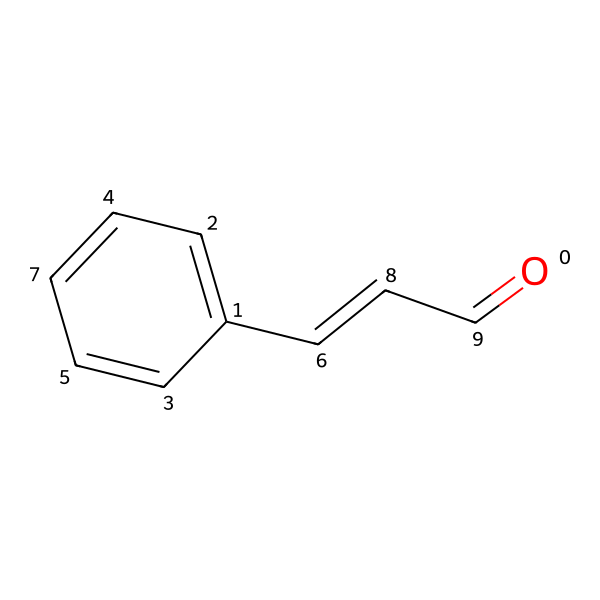

In [30]:
## visualization of ligand 
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Configuration for displaying in Jupyter notebooks
IPythonConsole.ipython_useSVG = True  # Use SVG for higher quality images
IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices
IPythonConsole.molSize = 600,600 # Set size of image

ligand = Chem.MolFromMolFile("ligand_files/637511.sdf")
ligand

In [31]:
! mk_export.py docking_results/637511.pdbqt -s docking_results/637511.sdf # In the original workshop, `mk_export.py` used the option `-o` instead of `-s`. This was changed to `-s` in late 2024.

In [32]:
import prolif as plf
import MDAnalysis as mda

pdb_id = "1e7u"

protein = mda.Universe(f"protein_files/protein_h.pdb")

In [33]:
# Load protein without hydrogens
protein = mda.Universe("protein_files/protein_h.pdb")
protein = protein.select_atoms("not (name H* or type H)")

# Let RDKit add hydrogens
protein_plf = plf.Molecule.from_mda(protein, NoImplicit=False)
poses_plf = plf.sdf_supplier("docking_results/637511.sdf") 

/opt/conda/lib/python3.11/site-packages/MDAnalysis/converters/RDKit.py:472: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


In [34]:
fp = plf.Fingerprint(count=True)

In [35]:
# run on your poses
fp.run_from_iterable(poses_plf, protein_plf) ## fill in this function

  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7fd5b4ab9990>

In [36]:
pose_index=1

In [61]:
fig = fp.plot_lignetwork(poses_plf[pose_index])
fig




In [55]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view



3Dmol.js failed to load for some reason. Please check your browser console for error messages.